# Case Study III: (2) Solving Laplace's equation with NumPy


In the first part of the case study we solved the Laplace equation with Python. In the second part, we will use NumPy.


In [1]:
import numpy as np

## Recap: Solving Laplace's or Poisson's equation

Still solving **Poisson's equation** for the electric potential $\Phi(\mathbf{r})$ and the charge density $\rho(\mathbf{r})$:

$$
\nabla^2 \Phi(x, y, z) = -4\pi\rho(x, y, z)\\
$$

For a region of space without charges ($\rho = 0$) this reduces to **Laplace's equation**

$$
\nabla^2 \Phi(x, y, z) = 0
$$


General solution by iteration:
$$
\Phi_{i,j} = \frac{1}{4}\Big(\Phi_{i+1,j} + \Phi_{i-1,j} + \Phi_{i,j+1} + \Phi_{i,j-1}\Big)
     + \pi\rho_{i,j} \Delta^2
$$

(For Laplace's equation, just set $\rho_{i,j} = 0$.)

### Jacobi method: Python
Do not change $\Phi_{i,j}$ until a complete sweep has been completed.

This is the algorithm from Part 1, packaged as a function:

In [2]:
def Laplace_Jacobi_python(Phi):
    """One update in the Jacobi algorithm (Python loop)"""
    Phi_new = Phi.copy()
    Nx, Ny = Phi.shape
    for xi in range(1, Nx-1):
        for yj in range(1, Ny-1):
            Phi_new[xi, yj] = 0.25*(Phi[xi+1, yj] + Phi[xi-1, yj]
                                  + Phi[xi, yj+1] + Phi[xi, yj-1])
    Phi[:, :] = Phi_new
    return Phi

## Jacobi method: NumPy
Do not change $\Phi_{i,j}$ until a complete sweep has been completed.


Fast implementation using numpy array operations (vectorized, run at C speed, not Python speed):

In [3]:
def Laplace_Jacobi(Phi):
    """One update in the Jacobi algorithm"""
    Phi[1:-1, 1:-1] = 0.25*(Phi[2:, 1:-1] + Phi[0:-2, 1:-1] + Phi[1:-1, 2:] + Phi[1:-1, 0:-2])
    return Phi

Note how much simpler the code becomes by using array operations.

If you are still wrapping your head around how the array slicing works, look at the following layouts of the array for each component of
```
Phi[1:-1, 1:-1] = 0.25*(Phi[2:, 1:-1] + Phi[0:-2, 1:-1] + Phi[1:-1, 2:] + Phi[1:-1, 0:-2])
```
which corresponds to
$$
\Phi_{i,j} = \frac{1}{4}\Big(\Phi_{i+1,j} + \Phi_{i-1,j} + \Phi_{i,j+1} + \Phi_{i,j-1}\Big)
$$
as the sum of
$$
\Phi_{i,j} = \frac{1}{4}\Big(\text{right neighbor} + \text{left neighbor} + \text{top neighbor} + \text{bottom neighbor}\Big)
$$
i.e.
$$
\begin{array}{ccc}
       & \Phi_{i, j+1} & \\
\Phi_{i-1, j} & \color{red}{{\Phi}_{i,j}} & \Phi_{i+1, j}\\
       & \Phi_{i, j-1} & 
\end{array}
$$

The whole potential (inside and boundaries), $\Phi_{i, j}$, $0 \le i < N_x$ and  $0 \le j < N_y$ 
```
Phi = 

100 100 100 100 100 100
  0   a   e   i   m   0
  0   b   f   j   n   0
  0   c   g   k   o   0
  0   d   h   l   p   0
  0   0   0   0   0   0
```

(Note that the array in row-column layout appears transposed compared to the x-y coordinates that we are using.)

The **inside of the box** $\Phi_{i, j}$, $1 \le i < N_x -1$ and  $1 \le j < N_y - 1$ 
```
Phi[1:-1, 1:-1] = 

 
      a   e   i   m    
      b   f   j   n    
      c   g   k   o    
      d   h   l   p    


```


The **right neigbors** $\Phi_{i+1, j}$, $2 \le i < N_x$ and  $1 \le j < N_y - 1$ (note that the right boundary is included)

```
Phi[2:, 1:-1] = 


      b   f   j   n  
      c   g   k   o   
      d   h   l   p   
      0   0   0   0   
```

(Confusingly, in the row-column layout, "right" neighbors looks like "bottom" neighbors).


The **left neighbors** $\Phi_{i-1, j}$, $0 \le i < N_x-2$ and  $1 \le j < N_y - 1$ (note that the left boundary, namely the wire at 100V, is included)
```
Phi[:-2, 1:-1] = 

    100 100 100 100  
      a   e   i   m    
      b   f   j   n    
      c   g   k   o    

```
(Confusingly, in the row-column layout, "left" neighbors looks like "top" neighbors).


The **top neighbors** $\Phi_{i, j+1}$, $1 \le i < N_x-1$ and  $2 \le j < N_y$ 
```
Phi[1:-1, 2:] = 


          e   i   m   0
          f   j   n   0
          g   k   o   0
          h   l   p   0

```


The **bottom neighbors**, $\Phi_{i, j-1}$, $1 \le i < N_x-1$ and  $0 \le j < N_y-2$ 
```
Phi[1:-1, :-2] = 

 
  0   a   e   i  
  0   b   f   j  
  0   c   g   k  
  0   d   h   l  
 
```

So, for example,
$$
\Phi_{1,1} = \frac{1}{4}\Big(\Phi_{2,1} + \Phi_{0,1} + \Phi_{1,2} + \Phi_{1,0}\Big)
$$
is calculated as 
```python
Phi[1, 1] = a = 0.25 * (b + 100 + e + 0)
```
by element-wise operations on the sliced arrays above.

### Speed-comparison

We learned that we **should avoid Python loops** and **use numpy array operations**. But does it really matter?

Let's run 20 iterations of the Jacobi algorithm and time it with `%%timeit`.


#### Python 

In [4]:
%%timeit 

Max_iter = 20

Nmax = 100
Phi = np.zeros((Nmax, Nmax), dtype=np.float64)

# initialize boundaries
# everything starts out zero so nothing special for the grounded wires
Phi[0, :] = 100     # wire at x=0 at 100 V

for n_iter in range(Max_iter):
    Phi[:, :] = Laplace_Jacobi_python(Phi)

232 ms ± 10 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### NumPy

In [5]:
%%timeit 

Max_iter = 20

Nmax = 100
Phi = np.zeros((Nmax, Nmax), dtype=np.float64)

# initialize boundaries
# everything starts out zero so nothing special for the grounded wires
Phi[0, :] = 100     # wire at x=0 at 100 V

for n_iter in range(Max_iter):
    Phi[:, :] = Laplace_Jacobi(Phi)

1.54 ms ± 223 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


#### And the winner is ... NumPy!
On my laptop, NumPy is about

In [13]:
232/1.54

150.64935064935065

~**150 times faster** than the Python loop! (Results may vary between 100 and 300 fold, depending on your computer etc. but speed-ups on the order of 100 are normal)

This is a massive speed gain, which will only improve with larger problem sizes.

Additionally, the code is much more readable.


## *Converged* solution of the wire-in-a-box problem

Solve the box-wire problem and **make sure that the solution is converged to  `tol = 1e-3`.**

Check convergence with the [_Frobenius Norm_](http://mathworld.wolfram.com/FrobeniusNorm.html):

$$
||\mathsf{\Phi}|| := \sqrt{\sum_{i,j}|\Phi_{ij}|^2}
$$

which is implemented as [numpy.linalg.norm()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html) when the argument is a matrix.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

Only execute the next line if you *don't* want interactive plotting (e.g., when exporting to LaTeX/PDF or html):

In [8]:
%matplotlib inline

### Convience plotting functions. 
If you provide a filename then output is only written to a file and figures are close to conserve memory. This allows you to plot files in loops and later assemble them into movies using other programs such as ffmpeg, ImageMagick, mencoder, QuickTime 7, ...

In [9]:
def plot_contour(Phi, filename=None, zlabel=r"potential $\Phi$ (V)",
                 cmap=plt.cm.coolwarm):
    """Plot Phi as a contour plot.
    
    Arguments
    ---------
    Phi : 2D array
          potential on lattice
    filename : string or None, optional (default: None)
          If `None` then show the figure and return the axes object.
          If a string is given (like "contour.png") it will only plot 
          to the filename and close the figure but return the filename.
    cmap : colormap
          pick one from matplotlib.cm          
    """
    fig = plt.figure(figsize=(5,4))
    ax = fig.add_subplot(111)

    x = np.arange(Phi.shape[0])
    y = np.arange(Phi.shape[1])
    X, Y = np.meshgrid(x, y)
    Z = Phi[X, Y]
    cset = ax.contourf(X, Y, Z, 20, cmap=cmap)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_aspect(1)

    cb = fig.colorbar(cset, shrink=0.5, aspect=5)
    cb.set_label(zlabel)
    
    if filename:
        fig.savefig(filename)
        plt.close(fig)
        return filename
    else:
        return ax
    

def plot_surf(Phi, filename=None, offset=-20, zlabel=r'potential $\Phi$ (V)',
             elevation=40, azimuth=-65, cmap=plt.cm.coolwarm):
    """Plot Phi as a 3D plot with contour plot underneath.
    
    Arguments
    ---------
    Phi : 2D array
          potential on lattice
    filename : string or None, optional (default: None)
          If `None` then show the figure and return the axes object.
          If a string is given (like "contour.png") it will only plot 
          to the filename and close the figure but return the filename.
    offset : float, optional (default: 20)
          position the 2D contour plot by offset along the Z direction
          under the minimum Z value
    zlabel : string, optional
          label for the Z axis and color scale bar
    elevation : float, optional
          choose elevation for initial viewpoint
    azimuth : float, optional
          chooze azimuth angle for initial viewpoint
    cmap : colormap
          pick one from matplotlib.cm
    """
     
    x = np.arange(Phi.shape[0])
    y = np.arange(Phi.shape[1])
    X, Y = np.meshgrid(x, y)
    Z = Phi[X, Y]
        
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_wireframe(X, Y, Z, rstride=2, cstride=2, linewidth=0.5, color="gray")
    surf = ax.plot_surface(X, Y, Z, cmap=cmap, alpha=0.6)
    cset = ax.contourf(X, Y, Z, 20, zdir='z', offset=offset+Z.min(), cmap=cmap)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel(zlabel)
    ax.set_zlim(offset + Z.min(), Z.max())
    
    ax.view_init(elev=elevation, azim=azimuth)

    cb = fig.colorbar(surf, shrink=0.5, aspect=5)
    cb.set_label(zlabel)
    
    if filename:
        fig.savefig(filename)
        plt.close(fig)
        return filename
    else:
        return ax

### Solution for the Wire-on-a-box problem

Use the faster Laplace solver: `Laplace_Jacobi()`

In [10]:
Max_iter=30000
tol = 1e-3
Nmax = 100
Phi = np.zeros((Nmax, Nmax), dtype=np.float64)
Phi_old = np.zeros_like(Phi)

# initialize boundaries
# everything starts out zero so nothing special for the grounded wires
Phi[0, :] = 100     # wire at x=0 at 100 V

for n_iter in range(Max_iter):
    Phi_old[:, :] = Phi
    Phi = Laplace_Jacobi(Phi)
    DeltaPhi = np.linalg.norm(Phi - Phi_old)
    if DeltaPhi < tol:
        print("Laplace_Jacobi converged in {0} iterations to {1}".format(n_iter+1, DeltaPhi))
        break
else:
    print("Laplace_Jacobi did NOT converge in {0} iterations, DeltaPhi={1}".format(n_iter+1, DeltaPhi))
    

Laplace_Jacobi converged in 13738 iterations to 0.0009998150508760593


Plot the result and visualy compare to what we had before:

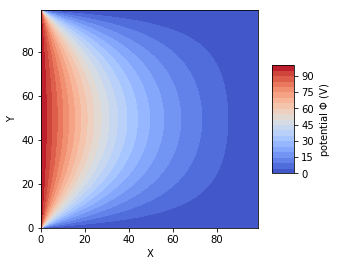

In [11]:
plot_contour(Phi)

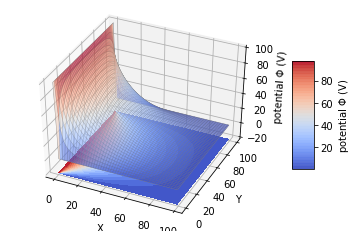

In [12]:
plot_surf(Phi)